In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [3]:
import sys
sys.path.append('../ptsne-pytorch')
from ptsne.ptsne import ParametricTSNE

# Datasets & Loaders

In [4]:
mnist_train = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [9]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
trainloader = torch.utils.data.DataLoader(mnist_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(mnist_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(mnist_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Classifier Network

In [6]:
class Net(nn.Module):
    def __init__(self, use_cuda=True):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 12x12x6 after pool
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 4x4x16 after pool
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
            
        self.proj_vals = {}

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        self.proj_vals['conv1'] = x.view(-1, 6 * 12 * 12)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        self.proj_vals['conv2'] = x
        x = F.relu(self.fc1(x))
        self.proj_vals['fc1'] =  x
        x = F.relu(self.fc2(x))
        self.proj_vals['fc2'] =  x
        x = self.fc3(x)
        self.proj_vals['fc3'] =  x
        return x

In [7]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(model.proj_vals[layer_key]), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).cpu().item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train Initial Network

In [8]:
epochs = 5

In [9]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic=True

net = Net(use_cuda=False)
# net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [10]:
for epoch in range(5):
        # log run every epoch

        train(200, net, 'cpu', trainloader, optimizer, criterion, epoch) # 'cuda'
        #test(net, 'cuda', testloader, criterion)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309242
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.592519
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.199516
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.036182
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.037689
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.214579
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.032351
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.072037
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.009607
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.045096
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.033037
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.013396
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.021232
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.049049
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.085056
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.081419
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.146526
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.074389
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.037087
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.003184
Train Epoch: 3 [2000

In [11]:
torch.save(net.state_dict(), 'models/mnist-before.pt')

# Embedding

In [146]:
layer_key = 'conv1' # which latent layer output should be used for embedding
embedding_size = 6 * 12 * 12 # what's the output size of this layer

In [147]:
net = Net(use_cuda=False)
net.load_state_dict(torch.load('models/mnist-before.pt'))
net.eval()
with torch.no_grad():
    logits_train = []
    for data, targets in trainloader_noshuffle:
#         data = data.cuda()
        out = net(data)
        
        logits_train.append(net.proj_vals[layer_key].cpu().detach())
logits_train = torch.cat(logits_train)

with torch.no_grad():
    logits_test = []
    for data, targets in testloader:
#         data = data.cuda()
        out = net(data)
        logits_test.append(net.proj_vals[layer_key].cpu().detach())
logits_test = torch.cat(logits_test)

In [148]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic=True

ptsne = ParametricTSNE(embedding_size, 2, 100, use_cuda=False, hidden_layer_dims=[300,100], alpha=1) # use_cuda=True
# ptsne.load_state_dict(torch.load('models/ptsne-test.pt'))

ptsne.fit(logits_train[::12], pretrain=True, verbose=True)

Calculating PCA
2020-09-28 10:29:21.212644: Beginning pretraining for 5 epochs
2020-09-28 10:29:21.512889: Loss after epoch 0: 242.76176166534424
2020-09-28 10:29:21.860410: Loss after epoch 1: 33.78375554084778
2020-09-28 10:29:22.187831: Loss after epoch 2: 11.010173738002777
2020-09-28 10:29:22.473294: Loss after epoch 3: 3.719105839729309
2020-09-28 10:29:22.745881: Loss after epoch 4: 2.098086401820183
2020-09-28 10:29:22.745881: Finished pretraining
Indexing
2020-09-28 10:29:34.539101: Beginning training for 10 epochs
2020-09-28 10:29:36.065969: Loss after epoch 1: 22.721180033390844
2020-09-28 10:29:37.318934: Loss after epoch 2: 20.263592188324484
2020-09-28 10:29:38.625151: Loss after epoch 3: 19.595849018168987
2020-09-28 10:29:39.908850: Loss after epoch 4: 18.611060500011142
2020-09-28 10:29:40.947916: Loss after epoch 5: 18.131580508480297
2020-09-28 10:29:42.277892: Loss after epoch 6: 17.747979573167243
2020-09-28 10:29:43.361295: Loss after epoch 7: 17.630088133212897
2

In [149]:
torch.save(ptsne.state_dict(), 'models/mnist-ptsne.pt')

In [150]:
ptsne.eval()
projected_train = ptsne(logits_train).detach().cpu() #logits_train.cuda()
projected_test = ptsne(logits_test).detach().cpu() #logits_test.cuda()

# Determine Suitable Shifts

In [181]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

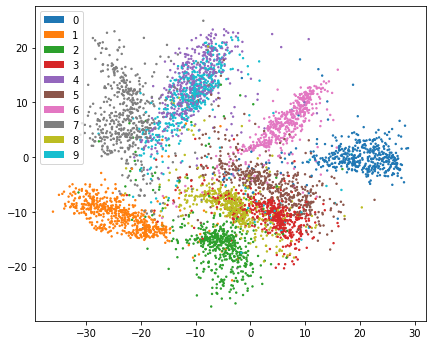

In [182]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(projected_train[::12,0], projected_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [256]:
labels_train = mnist_train.targets
shifted_train = projected_train.clone()

for i in range(10):
    shifted_train[labels_train == i] = (1./2. * projected_train[(labels_train == i)] + 1./4. * projected_train[(labels_train == i)].mean(axis=0)) + torch.tensor([0.,0])

In [257]:
shifted_train[labels_train == 9] += torch.tensor([7.,7.])
shifted_train[labels_train == 4] += torch.tensor([-2.,7.])

In [258]:
# labels_train = mnist_train.targets
# shifted_train = projected_train.clone()
# shifted_train[labels_train == 3] = (1./2. * projected_train[(labels_train == 3)] + 1./4. * projected_train[(labels_train == 3)].mean(axis=0)) + torch.tensor([-10.,-7.])
# shifted_train[labels_train == 8] = (3./4. * projected_train[(labels_train == 8)] + 1./4. * projected_train[(labels_train == 8)].mean(axis=0)) + torch.tensor([3.,3.])
# shifted_train[labels_train == 4] = (1./2. * projected_train[(labels_train == 4)] + 1./4. * projected_train[(labels_train == 4)].mean(axis=0)) + torch.tensor([7.,-10.])

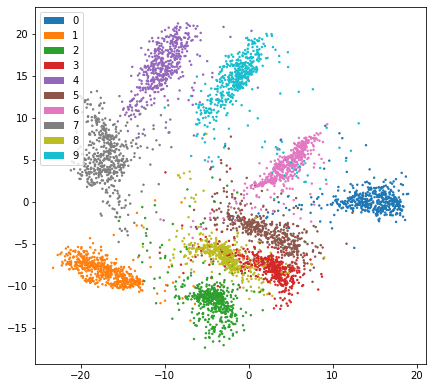

In [259]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(shifted_train[::12,0], shifted_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

# Retraining

In [260]:
epochs = 4

In [261]:
shifted_dataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float() / 255., shifted_train, mnist_train.targets)
shifted_loader = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=True)
shifted_loader_noshuffle = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=False)

In [262]:
# train network using the altered embedded points

torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic=True

net = Net(use_cuda=False)
net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(epochs):
    train_altered(200, net, 'cpu', shifted_loader, ptsne, optimizer, epoch, 0.5) #'cuda'

torch.save(net.state_dict(), 'models/mnist-after.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.299441
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.095932
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.080335
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.105190
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.051315
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.112390
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.079705
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.041958
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.053619
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.056193
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.066017
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.063946
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.089169
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.065064
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.082729
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.103069
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.103368
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.084636
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.086246
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.073377
Train Epoch: 3 [2000

In [64]:
# train network as usual, for better comparability

net = Net(use_cuda=False)
net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(epochs):
    train(200, net, 'cpu', trainloader, optimizer, criterion, epoch) # 'cuda'

torch.save(net.state_dict(), 'models/mnist-after-baseline.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.012237
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.143352
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.012943
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.035887
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.006986
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.004517
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.062546
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.017745
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.014931
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.123465
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.004452
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.076482
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.022024
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.002691
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.014893
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.000308
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.006623
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.011104
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.006575
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.066610
Train Epoch: 3 [2000

#### calculate output for train and test sets over all methods

In [159]:
# outputs for initial model (trained for 5 epochs)
net = Net(use_cuda=False)
net.load_state_dict(torch.load('models/mnist-before.pt'))
net.eval()
with torch.no_grad():
    projected_train_before = []
    logits_train_before = []
    for data, targets in trainloader_noshuffle:
        out = net(data) # data.cuda()
        logits_train_before.append(out.detach().cpu())
        projected_train_before.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    projected_train_before = torch.cat(projected_train_before)
    logits_train_before = torch.cat(logits_train_before)

    projected_test_before = []
    logits_test_before = []
    for data, targets in testloader:
        out = net(data) # data.cuda()
        logits_test_before.append(out.detach().cpu())
        projected_test_before.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    projected_test_before = torch.cat(projected_test_before)
    logits_test_before = torch.cat(logits_test_before)

In [160]:
# outputs for baseline model (trained for 5 + 4 epochs)
net = Net(use_cuda=False)
net.load_state_dict(torch.load('models/mnist-after-baseline.pt'))
net.eval()
with torch.no_grad():
    projected_train_baseline = []
    logits_train_baseline = []
    for data, targets in trainloader_noshuffle:
        out = net(data) # data.cuda()
        logits_train_baseline.append(out.detach().cpu())
        projected_train_baseline.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    projected_train_baseline = torch.cat(projected_train_baseline)
    logits_train_baseline = torch.cat(logits_train_baseline)

    projected_test_baseline = []
    logits_test_baseline = []
    for data, targets in testloader:
        out = net(data) # data.cuda()
        logits_test_baseline.append(out.detach().cpu())
        projected_test_baseline.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    projected_test_baseline = torch.cat(projected_test_baseline)
    logits_test_baseline = torch.cat(logits_test_baseline)

In [263]:
# outputs for model using latent interventions (trained for 5 + 4 epochs)
net = Net(use_cuda=False)
net.load_state_dict(torch.load('models/mnist-after.pt'))
net.eval()
with torch.no_grad():
    projected_train_altered = []
    logits_train_altered = []
    for data, targets in trainloader_noshuffle:
        out = net(data) # data.cuda()
        logits_train_altered.append(out.detach().cpu())
        projected_train_altered.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    projected_train_altered = torch.cat(projected_train_altered)
    logits_train_altered = torch.cat(logits_train_altered)

    projected_test_altered = []
    logits_test_altered = []
    for data, targets in testloader:
        out = net(data) # data.cuda()
        logits_test_altered.append(out.detach().cpu())
        projected_test_altered.append(ptsne(net.proj_vals[layer_key]).detach().cpu())
    projected_test_altered = torch.cat(projected_test_altered)
    logits_test_altered = torch.cat(logits_test_altered)

# Evaluation

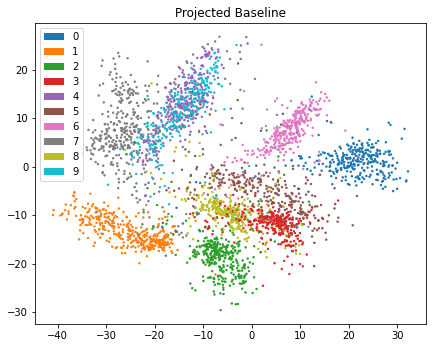

In [264]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_test.targets[::3]]
ax.scatter(projected_test_baseline[::3,0], projected_test_baseline[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)
plt.title("Projected Baseline")
plt.show()

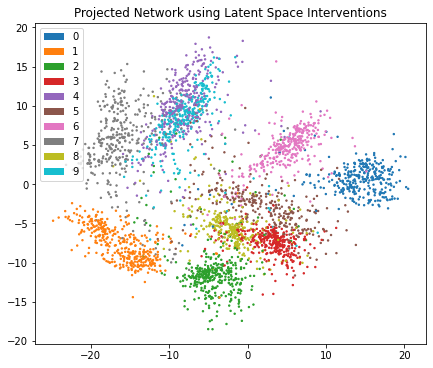

In [265]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_test.targets[::3]]
ax.scatter(projected_test_altered[::3,0], projected_test_altered[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

plt.title("Projected Network using Latent Space Interventions")
plt.show()

In [266]:
cf_train_before = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train_before.argmax(dim=1)):
    cf_train_before[i] += 1

cf_test_before = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test_before.argmax(dim=1)):
    cf_test_before[i] += 1

In [267]:
cf_train_baseline = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train_baseline.argmax(dim=1)):
    cf_train_baseline[i] += 1

cf_test_baseline = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test_baseline.argmax(dim=1)):
    cf_test_baseline[i] += 1

In [268]:
cf_train_altered = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train_altered.argmax(dim=1)):
    cf_train_altered[i] += 1

cf_test_altered = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test_altered.argmax(dim=1)):
    cf_test_altered[i] += 1

In [269]:
# baseline accuracy
cf_test_baseline.diag().sum().float() / cf_test_baseline.sum().float()

tensor(0.9865)

In [270]:
# intervention accuracy
cf_test_altered.diag().sum().float() / cf_test_altered.sum().float()

tensor(0.9900)

In [271]:
cf_test_before

tensor([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
        [   0, 1127,    0,    2,    0,    0,    0,    2,    4,    0],
        [   1,    0, 1021,    0,    1,    0,    0,    5,    4,    0],
        [   0,    0,    3,  994,    0,    5,    0,    4,    3,    1],
        [   0,    0,    2,    0,  976,    0,    1,    1,    0,    2],
        [   2,    0,    0,    3,    0,  877,    7,    1,    2,    0],
        [   0,    2,    0,    0,    3,    1,  952,    0,    0,    0],
        [   0,    1,    1,    1,    0,    0,    0, 1022,    2,    1],
        [   4,    0,    2,    1,    0,    2,    1,    3,  958,    3],
        [   0,    1,    0,    4,   10,    5,    0,    8,    9,  972]])

In [272]:
cf_test_baseline

tensor([[ 975,    2,    0,    0,    0,    0,    1,    1,    1,    0],
        [   0, 1125,    0,    7,    0,    0,    1,    2,    0,    0],
        [   1,    0, 1013,    7,    1,    0,    0,    8,    2,    0],
        [   0,    0,    1, 1003,    0,    2,    0,    1,    3,    0],
        [   0,    0,    1,    0,  974,    0,    0,    1,    0,    6],
        [   1,    0,    0,   13,    0,  874,    2,    1,    1,    0],
        [   3,    2,    0,    2,    3,    5,  941,    0,    2,    0],
        [   0,    3,    1,    5,    0,    0,    0, 1016,    2,    1],
        [   1,    0,    2,   10,    0,    3,    0,    1,  956,    1],
        [   0,    0,    1,    7,    1,    6,    0,    4,    2,  988]])

In [273]:
cf_test_altered

tensor([[ 975,    0,    0,    0,    0,    1,    1,    2,    1,    0],
        [   0, 1131,    0,    2,    0,    0,    0,    0,    2,    0],
        [   1,    1, 1027,    0,    1,    0,    0,    2,    0,    0],
        [   0,    0,    2, 1005,    0,    2,    0,    1,    0,    0],
        [   0,    0,    0,    0,  973,    0,    1,    0,    0,    8],
        [   1,    0,    0,    7,    0,  879,    1,    1,    3,    0],
        [   4,    2,    0,    0,    3,    7,  941,    0,    1,    0],
        [   0,    4,    5,    2,    0,    0,    0, 1013,    2,    2],
        [   1,    0,    2,    2,    1,    1,    0,    1,  961,    5],
        [   0,    1,    0,    4,    3,    3,    0,    2,    1,  995]])

In [274]:
def prec(cf, l):
    return cf[l,l].float() / cf[:,l].sum().float()
def rec(cf, l):
    return cf[l,l].float() / cf[l,:].sum().float()
def f1(cf, l):
    return 2 * prec(cf, l) * rec(cf, l) / (prec(cf, l) + rec(cf, l))

In [277]:
# print(prec(cf_test_baseline, 3))
# print(rec(cf_test_baseline, 3))
# print(f1(cf_test_baseline, 3))

# print(prec(cf_test_baseline, 8))
# print(rec(cf_test_baseline, 8))
# print(f1(cf_test_baseline, 8))

print(f1(cf_test_baseline, 4))
print(f1(cf_test_baseline, 9))

tensor(0.9934)
tensor(0.9855)


In [278]:
# print(prec(cf_test_altered, 3))
# print(rec(cf_test_altered, 3))
# print(f1(cf_test_altered, 3))

# print(prec(cf_test_altered, 8))
# print(rec(cf_test_altered, 8))
# print(f1(cf_test_altered, 8))

print(f1(cf_test_altered, 4))
print(f1(cf_test_baseline, 9))

tensor(0.9913)
tensor(0.9855)
